In [3]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import torchvision.transforms as transforms
import numpy as np
import skimage
import torch

In [ ]:
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

In [4]:
type(ssd_model)

PyTorch.Detection.SSD.ssd.model.SSD300

In [4]:
images = ['000000447200.jpg',  '000000367680.jpg',  '000000465718.jpg', '000000319721.jpg', '000000383289.jpg']

In [59]:
def rescale(img, input_height, input_width):
    aspect = img.shape[1]/float(img.shape[0])
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    return imgScaled

def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

def normalize(img, mean=128, std=128):
    img = (img * 256 - mean) / std
    return img

def prepare_input(img_uri):
    img = cv2.imread(img_uri)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = rescale(img, 300, 300)
    img = crop_center(img, 300, 300)
    img = normalize(img)
    img = img.astype(np.float32)
    return img

def prepare_tensor(inputs):
    transform = transforms.ToTensor()
    tensor = torch.stack([transform(input) for input in inputs])

    return tensor


In [60]:
@torch.no_grad()
def inference(tensor, model):
    detections_batch = model(tensor)
    return detections_batch



In [18]:
with open('category_names.txt', 'r') as file:
    classes_to_labels = file.readlines()
    classes_to_labels = [line.strip() for line in classes_to_labels]

print(', '.join(classes_to_labels))

person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush


In [61]:
def detect_objects(image):
  input = prepare_input(image)

  tensor = prepare_tensor([input]).to('cuda')

  detections_batch = inference(tensor, ssd_model)

  results_per_input = utils.decode_results(detections_batch)

  best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]


  for det_result in best_results_per_input:
    bbox = det_result[0].tolist()
    score = det_result[2].tolist()
    class_names_from_indices = lambda indices: [classes_to_labels[idx-1] for idx in indices]
    classes = class_names_from_indices(det_result[1].tolist())

    return {'bbox': bbox,'class': classes, 'score': score}

In [57]:
def show_detections(result_dict, img):
  fig, ax = plt.subplots(1)
  image = prepare_input(img) / 2 + 0.5
  ax.imshow(image)

  bboxes = result_dict['bbox']
  classes = result_dict['class']
  confidences = result_dict['score']

  for idx in range(len(bboxes)):
      left, bot, right, top = bboxes[idx]
      x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='b', facecolor='none')
      ax.add_patch(rect)
      ax.text(x, y, "{} {:.0f}%".format(classes[idx], confidences[idx]*100), color='red', fontsize=10)
  plt.show()

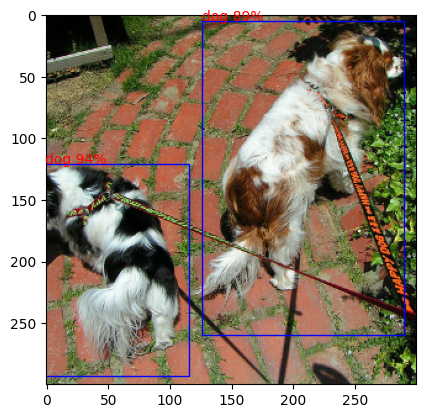

{'bbox': [[0.420049250125885,
   0.01583683490753174,
   0.9668030142784119,
   0.8647446036338806],
  [-0.004483252763748169,
   0.4019996225833893,
   0.38409456610679626,
   0.9755164384841919]],
 'class': ['dog', 'dog'],
 'score': [0.8879238963127136, 0.939863920211792]}

In [64]:
image = '000000447200.jpg'
res_detection = detect_objects(image)
show_detections(res_detection, image)
res_detection

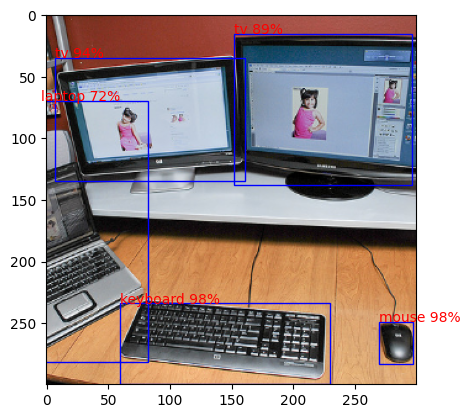

{'bbox': [[-0.014865472912788391,
   0.23181447386741638,
   0.2741880416870117,
   0.9368463754653931],
  [0.5068675875663757,
   0.04944266378879547,
   0.9894228577613831,
   0.4580930471420288],
  [0.023420214653015137,
   0.11499808728694916,
   0.5365632772445679,
   0.4489966034889221],
  [0.8996526002883911,
   0.830390453338623,
   0.9913939237594604,
   0.9441670179367065],
  [0.1990673542022705,
   0.7792383432388306,
   0.7663307189941406,
   0.9963716268539429]],
 'class': ['laptop', 'tv', 'tv', 'mouse', 'keyboard'],
 'score': [0.7217973470687866,
  0.8894323110580444,
  0.9437037110328674,
  0.9835667610168457,
  0.9848082065582275]}

In [66]:
image = '000000465718.jpg'
res_detection = detect_objects(image)
show_detections(res_detection, image)
res_detection

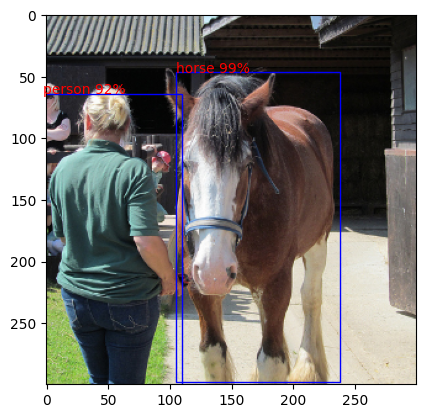

{'bbox': [[-0.009712114930152893,
   0.21191060543060303,
   0.36586833000183105,
   1.0008487701416016],
  [0.34932929277420044,
   0.15435436367988586,
   0.7945056557655334,
   0.9919366836547852]],
 'class': ['person', 'horse'],
 'score': [0.9178879261016846, 0.9886364340782166]}

In [67]:
image = '000000319721.jpg'
res_detection = detect_objects(image)
show_detections(res_detection, image)
res_detection

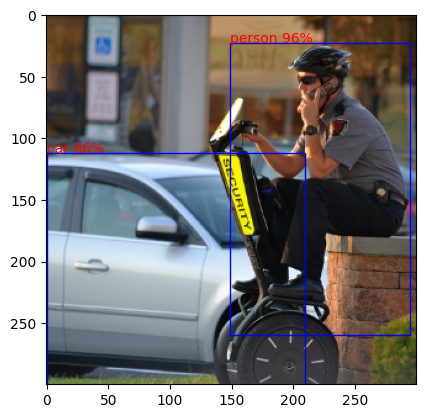

{'bbox': [[-9.79006290435791e-05,
   0.3726698160171509,
   0.6980820894241333,
   1.0001623630523682],
  [0.4952854514122009,
   0.07386887073516846,
   0.9819565415382385,
   0.8651570677757263]],
 'class': ['car', 'person'],
 'score': [0.861495852470398, 0.9582232236862183]}

In [68]:
image = '000000383289.jpg'
res_detection = detect_objects(image)
show_detections(res_detection, image)
res_detection